In [65]:


import numpy as np
import pandas as pd 
from pathlib import Path
from pulp import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time 
import scipy.stats as stats

from io import BytesIO #apparanetly needed for reading the files from the bucket
from google.cloud import storage

In [66]:
storage_client = storage.Client()
# Define the bucket name and file name
bucket_name = 'memory_represetnations_data'
file_name = 'images_info_multicat.csv' #you can also try to load something that is not within a subfolder: i.e: 'Object and scene categories in brain and behavior/set1.csv'

# Get the bucket and blob objects
bucket = storage_client.get_bucket(bucket_name)

def read_csv_from_bucket(bucket,filename):
    blob = bucket.blob(filename)

    # Read the content of the file into a BytesIO object
    content = blob.download_as_string()
    content = BytesIO(content)

    # Load the content into a pandas DataFrame using pd.read_csv
    df = pd.read_csv(content)
    return df

def save_df_csv_into_bucket(bucket,df,filename):
    output_blob = bucket.blob(filename)
    output_blob.upload_from_string(df.to_csv(index=False), content_type='text/csv')
    
    

In [67]:
#here is how to read it: 
test_df=read_csv_from_bucket(bucket=bucket,filename=file_name)
#here is how to save with a new name: 
test_filename='dekels_bucket_save_test.csv'
save_df_csv_into_bucket(bucket,df,test_filename)


In [30]:
#example on how to list all bucket contents
blobs = bucket.list_blobs()
# Print the names of all the blobs
for blob in blobs:

    print(blob.name)

.ipynb_checkpoints/
Object and scene categories in brain and behavior/set1.csv
Object and scene categories in brain and behavior/set1/0001.jpg
Object and scene categories in brain and behavior/set1/0002.jpg
Object and scene categories in brain and behavior/set1/0003.jpg
Object and scene categories in brain and behavior/set1/0004.jpg
Object and scene categories in brain and behavior/set1/0005.jpg
Object and scene categories in brain and behavior/set1/0006.jpg
Object and scene categories in brain and behavior/set1/0007.jpg
Object and scene categories in brain and behavior/set1/0008.jpg
Object and scene categories in brain and behavior/set1/0009.jpg
Object and scene categories in brain and behavior/set1/0010.jpg
Object and scene categories in brain and behavior/set1/0011.jpg
Object and scene categories in brain and behavior/set1/0012.jpg
Object and scene categories in brain and behavior/set1/0013.jpg
Object and scene categories in brain and behavior/set1/0014.jpg
Object and scene categori

In [101]:
similairy_dfs_paths = ['similarity_df_regular/similarity_between_pairs_VGGbadlands.csv',
'similarity_df_regular/similarity_between_pairs_VGGbridge.csv',
'similarity_df_regular/similarity_between_pairs_VGGgolf_course.csv',
'similarity_df_regular/similarity_between_pairs_VGGhighway.csv',
'similarity_df_regular/similarity_between_pairs_VGGmountain.csv',
'similarity_df_regular/similarity_between_pairs_VGGplayground.csv']

In [38]:
similairy_dfs_paths[0].split('VGG')[-1].split('.')[0]

'badlands'

In [102]:
duplicate_images = ['playground_3.pkl','bridge_219.pkl','highway_106.pkl','highway_109.pkl','highway_119.pkl',
                    'golf_course_24.pkl',
                    'highway_121.pkl','highway_130.pkl','highway_140.pkl','highway_157.pkl','highway_170.pkl',
                    'highway_180.pkl','highway_191.pkl','highway_248.pkl','highway_377.pkl','highway_411.pkl','highway_70.pkl','highway_274.pkl','highway_198.pkl',
                    'mountain_119.pkl','mountain_172.pkl','mountain_121.pkl','mountain_45.pkl','mountain_74.pkl','mountain_91.pkl','mountain_194.pkl','mountain_87.pkl','mountain_305.pkl']

In [ ]:
results = pd.DataFrame([])
all_selected_images_dict = {}

for cat in similairy_dfs_paths:


    category_name = cat.split('VGG')[-1].split('.')[0]
    print(category_name)

    cur_similarity_df = read_csv_from_bucket(bucket=bucket,filename=cat)

    # removing duplicate images:
    bad_images_cat = [img for img in duplicate_images if category_name in img]
    for bad_img in bad_images_cat:

        bad_idx = cur_similarity_df[(cur_similarity_df['image1'] == bad_img) | (cur_similarity_df['image2'] == bad_img)].index
        cur_similarity_df = cur_similarity_df.drop(index=bad_idx)
        

    cur_similarity_df['image1'] = cur_similarity_df['image1'].str.replace('.pkl','.jpg')
    cur_similarity_df['image2'] = cur_similarity_df['image2'].str.replace('.pkl','.jpg')

    cur_similarity_df['mean_network_sim']=cur_similarity_df[[colname for colname in cur_similarity_df.columns if 'level' in colname]].mean(axis=1)
    all_unique_images=(set(cur_similarity_df['image1'].values) | set(cur_similarity_df['image2'].values))
    number_of_images = len(all_unique_images)
    cur_similarity_df['numeric_image1']=cur_similarity_df['image1'].copy()
    cur_similarity_df['numeric_image2']=cur_similarity_df['image2'].copy()

    names_to_numbers_dict={name:i for (name,i) in zip(all_unique_images,range(number_of_images))}
    numbers_to_names_dict={name:key for key,name in names_to_numbers_dict.items()}
    cur_similarity_df['numeric_image1'].replace(names_to_numbers_dict,inplace=True)
    cur_similarity_df['numeric_image2'].replace(names_to_numbers_dict,inplace=True)

    d_matrix_level_dict = {}
    for j,sim_level in enumerate(['level_0','level_6','mean_network_sim']):
        #get from the network: 
        curr_sim_df_for_correlation=cur_similarity_df.copy()
        d_matrix=np.zeros([number_of_images,number_of_images])
        for i in range(len(curr_sim_df_for_correlation)):
            row=curr_sim_df_for_correlation['numeric_image1'].iloc[i]
            col=curr_sim_df_for_correlation['numeric_image2'].iloc[i]
            val=curr_sim_df_for_correlation[sim_level].iloc[i]
            d_matrix[row,col]=1-val
            d_matrix[col,row]=1-val
            d_matrix[row,row]=0

        d_matrix_level_dict[sim_level] = d_matrix
        
    SIM_M = d_matrix_level_dict['level_6'] - d_matrix_level_dict['level_0']
    SIM_Mean = d_matrix_level_dict['mean_network_sim']


    epsilon_size = [0.05]
    # Define the epsilon value
    for epsilon in epsilon_size:
        print(f'Epsilon size {epsilon}')
        start_time = time.time()

        # Set the size of the matrix
        n = SIM_M.shape[0]
        n_images = n
        images_to_select=10

        # Define the problem
        prob = LpProblem("Image Selection", LpMaximize)
        # Define the decision variables
        x = LpVariable.dicts("x", range(n_images), 0, 1, LpBinary)
        y = LpVariable.dicts("y", (range(n_images), range(n_images)), 0, 1, LpBinary)
        z = LpVariable.dicts("z", (range(n_images), range(n_images)), 0, 1, LpBinary)

        # Define the objective function
        prob += lpSum([SIM_M[i][j]*z[i][j]-SIM_M[i][j]*y[i][j] for i in range(n_images) for j in range(n_images)])
        #make sure only "images_to_select" are selected:
        prob += lpSum([x[i] for i in range(n_images)]) == images_to_select
        #make sure that the averages are close up tp epsilon: 
        prob += lpSum([SIM_Mean[i][j]*y[i][j] for i in range(n_images) for j in range(n_images)]) - lpSum([SIM_Mean[i][j]*z[i][j] for i in range(n_images) for j in range(n_images)])<=epsilon
        prob += lpSum([SIM_Mean[i][j]*y[i][j] for i in range(n_images) for j in range(n_images)]) - lpSum([SIM_Mean[i][j]*z[i][j] for i in range(n_images) for j in range(n_images)])>=-epsilon


        for i in range(n_images):
            prob += lpSum([y[j][i] for j in range(n_images)]) == x[i]
            prob += lpSum([z[j][i] for j in range(n_images)]) == x[i]

            prob += (x[i] + lpSum([y[i][j] for j in range(n_images)]) + lpSum([z[i][j] for j in range(n_images)]) )<= 1

            for j in range(n_images):
                if i == j:
                    prob += z[i][j] == 0
                    prob += y[i][j] == 0
                prob += y[j][i] <= x[i]
                prob += z[j][i] <= x[i]


        # Solve the problem
        prob.solve()
        # Print the status of the problem
        print("Status:", LpStatus[prob.status])
        # Print selected targets and D1 and D2 images 
        selected_target_and_distractors_dict ={}
        for i in range(n_images):
            if x[i].value() == 1:
                #print(f"Target {i}:")
                # high level distractor
                y1 = [j for j in range(n_images) if y[j][i].value() == 1]
                # low level distractor
                z2 = [j for j in range(n_images) if z[j][i].value() == 1]
                #print(f" y1: {y1}")
                #print(f" z2: {z2}")
                selected_target_and_distractors_dict[i] = (z2,y1)

        #print('x:\n',[x[j].value() for j in range(n_images)])
        y_vals=np.array([y[i][j].value() for i in range(n_images) for j in range(n_images)]).reshape([n_images,n_images])
        #print('y:\n',y_vals)
        z_vals=np.array([z[i][j].value() for i in range(n_images) for j in range(n_images)]).reshape([n_images,n_images])
        #print('z:\n',z_vals)
        end_time = time.time()

        selected_target_and_distractors_names_dict = {}
        for key , value in selected_target_and_distractors_dict.items():
            
            # Convert the first value in the tuple to a word using the second dictionary
            word1 = numbers_to_names_dict[value[0][0]]
            word1 = word1.replace('.pkl','.jpg')
            # Convert the second value in the tuple to a word using the second dictionary
            word2 = numbers_to_names_dict[value[1][0]]
            word2 = word2.replace('.pkl','.jpg')
            # Look up the word corresponding to the key in the second dictionary
            new_key = numbers_to_names_dict[key]
            new_key = new_key.replace('.pkl','.jpg')
            # Add the new key-value pair to the new dictionary
            selected_target_and_distractors_names_dict[new_key] = word1, word2


        sim_df_selected = pd.DataFrame([])
        for key,values in selected_target_and_distractors_names_dict.items():
            target_sim_df = cur_similarity_df[(cur_similarity_df['image1']== key) | (cur_similarity_df['image2'] == key)]

            dist_0_sim_df = target_sim_df[(target_sim_df['image1']== values[0]) | (target_sim_df['image2'] == values[0])]
            dist_0_sim_df['distractor_level'] = 0
            dist_1_sim_df = target_sim_df[(target_sim_df['image1']== values[1]) | (target_sim_df['image2'] == values[1])]
            dist_1_sim_df['distractor_level'] = 1
            sim_df_selected = pd.concat([sim_df_selected,dist_0_sim_df,dist_1_sim_df])


        elapsed_time = (end_time - start_time)/60
        mean_sim_per_layer = sim_df_selected.groupby('distractor_level')[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].mean()
        mean_similarity = mean_sim_per_layer.mean(axis=1)
        
        d1 = sim_df_selected[sim_df_selected['distractor_level'] == 0 ]['mean_network_sim']
        d2 = sim_df_selected[sim_df_selected['distractor_level'] == 1 ]['mean_network_sim']

        t_stat, p_value = stats.ttest_rel(d1, d2)
        cur_run_line = pd.DataFrame([{'category name':category_name, 'epsilon':epsilon,'d1 mean': mean_similarity[0],'d2 mean': mean_similarity[1],'elapse time':elapsed_time,'p val':p_value,'t stat':t_stat}])
        results = pd.concat([results,cur_run_line])
        key_name = category_name +'_'+ str(epsilon)
        all_selected_images_dict[key_name] = sim_df_selected


badlands


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.


Epsilon size 0.05


/opt/conda/lib/python3.7/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /var/tmp/338682052d1241bf8037d754cfe34666-pulp.mps max timeMode elapsed branch printingOptions all solution /var/tmp/338682052d1241bf8037d754cfe34666-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 108816 COLUMNS
At line 1078113 RHS
At line 1186925 BOUNDS
At line 1294806 ENDATA
Problem MODEL has 108811 rows, 107880 columns and 646352 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.3984 - 5.71 seconds
Cgl0002I 464 variables fixed
Cgl0008I 232 inequality constraints converted to equality constraints
Cgl0005I 232 SOS with 107648 members
Cgl0004I processed model has 107882 rows, 107648 columns (107648 integer (107648 of which binary)) and 537080 elements
Cbc0038I Initial state - 4 integers unsatisfied sum - 0.94586
Cbc0038

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epsilon size 0.05
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /var/tmp/5c09c60cb39f4abba7ecd5b43826be0d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/tmp/5c09c60cb39f4abba7ecd5b43826be0d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 142850 COLUMNS
At line 1416991 RHS
At line 1559837 BOUNDS
At line 1701616 ENDATA
Problem MODEL has 142845 rows, 141778 columns and 849604 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.48166 - 6.12 seconds
Cgl0002I 532 variables fixed
Cgl0008I 266 inequality constraints converted to equality constraints
Cgl0005I 266 SOS with 141512 members
Cgl0004I processed model has 141780 rows, 141512 columns (141512 integer (141512 of which binary)) and 706230 elements
Cbc0038I Initial state - 10 integers unsatisfied s

In [ ]:
cur_similarity_df[cur_similarity_df['mean_network_sim'] > 0.89]

In [98]:
results

,category name,epsilon,d1 mean,d2 mean,elapse time,p val,t stat
0,mountain,0.05,0.3882,0.392459,7.188823,0.875457,-0.161252


In [70]:
sim

dict_keys(['badlands_0.05', 'bridge_0.05', 'golf_course_0.05', 'highway_0.05', 'mountain_0.05', 'playground_0.05'])

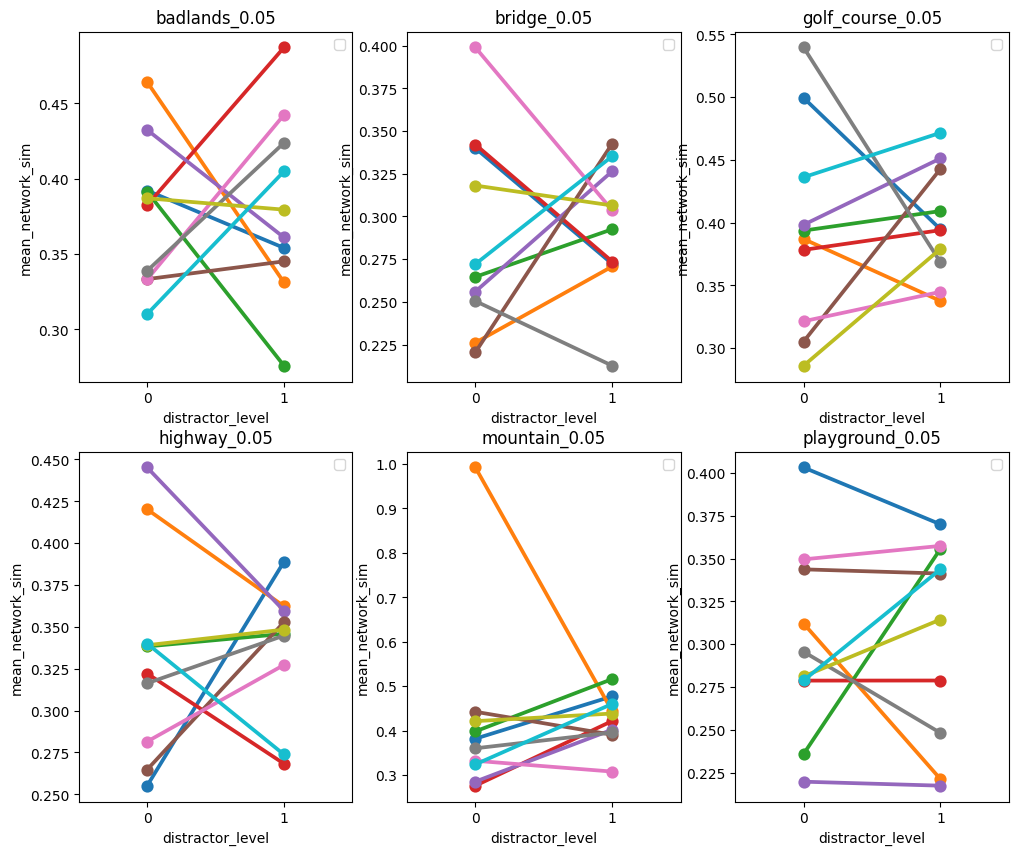

In [83]:
import seaborn as sns
fig,axes = plt.subplots(2,3,figsize = (12,10))
axes = axes.ravel()
numbers = []
for i in range(1,11):
    numbers.append(i)
    numbers.append(i)


for i,cat in enumerate(all_selected_images_dict.keys()):
    df = all_selected_images_dict[cat]
    df['ID'] = numbers
    sns.pointplot(data=df,x='distractor_level', y='mean_network_sim', hue='ID',ax=axes[i])
    axes[i].set_title(cat)
    axes[i].legend('')
   

In [84]:
colors = ['red','blue','green', 'red','orange','purple']
fig,ax = plt.subplots()
for i,cat in enumerate(epsilon_2_cat):
    df = all_selected_images_dict[cat]
    y = df.groupby('distractor_level')[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].mean()
    
    y_std = df.groupby('distractor_level')[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].std()
    x = ['level_0','level_1','level_2','level_3','level_4','level_5','level_6']
    ax.plot(x, y, label=cat,color=colors[i])
    ax.fill_between(x, y - y_std, y + y_std,color=colors[i], alpha=0.1)


ax.legend()

,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6,model,category1,category2,mean_network_sim,numeric_image1,numeric_image2,distractor_level,ID
9699,mountain_128.jpg,mountain_156.jpg,0.577685,0.403906,0.298845,0.312912,0.242444,0.431524,0.405357,VGG,mountain,mountain,0.381810,286,52,0,1
17913,mountain_156.jpg,mountain_295.jpg,0.372946,0.354216,0.271074,0.272396,0.489333,0.763428,0.816601,VGG,mountain,mountain,0.477142,52,219,1,1
27364,mountain_194.jpg,mountain_74.jpg,0.995102,0.986461,0.986155,0.988182,0.993212,0.997370,0.997527,VGG,mountain,mountain,0.992001,64,66,0,2
34826,mountain_230.jpg,mountain_74.jpg,0.405956,0.301252,0.211153,0.242998,0.350772,0.744183,0.850479,VGG,mountain,mountain,0.443828,240,66,1,2
39833,mountain_262.jpg,mountain_44.jpg,0.549125,0.396545,0.309270,0.340297,0.322259,0.466276,0.403950,VGG,mountain,mountain,0.398246,82,165,0,3
1102,mountain_100.jpg,mountain_262.jpg,0.449089,0.362753,0.283647,0.316787,0.502127,0.820918,0.876183,VGG,mountain,mountain,0.515929,27,82,1,3
8549,mountain_123.jpg,mountain_94.jpg,0.478399,0.371338,0.243143,0.167504,0.158210,0.305985,0.207915,VGG,mountain,mountain,0.276070,119,18,0,4
8345,mountain_123.jpg,mountain_189.jpg,0.413672,0.328392,0.246539,0.275310,0.265063,0.658684,0.763559,VGG,mountain,mountain,0.421603,119,297,1,4
23769,mountain_179.jpg,mountain_67.jpg,0.470891,0.361135,0.223494,0.192898,0.136696,0.310142,0.301706,VGG,mountain,mountain,0.285280,270,148,0,5
30281,mountain_207.jpg,mountain_67.jpg,0.382145,0.310003,0.213005,0.211454,0.264758,0.650267,0.782876,VGG,mountain,mountain,0.402072,74,148,1,5


In [71]:
save_df_csv_into_bucket(bucket,results,'results_epsilon_0.05.csv')

In [56]:
save_df_csv_into_bucket(bucket,all_selected_images_dict,'dict_epsilon_0.1.csv')

AttributeError: 'dict' object has no attribute 'to_csv'

In [99]:
save_df_csv_into_bucket(bucket,all_selected_images_dict['mountain_0.05'],'mountain_epsilon_0.05.csv')

In [100]:
all_selected_images_dict['mountain_0.05']

,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6,model,category1,category2,mean_network_sim,numeric_image1,numeric_image2,distractor_level
27142,mountain_193.jpg,mountain_57.jpg,0.590676,0.405312,0.277325,0.288993,0.352233,0.498792,0.486187,VGG,mountain,mountain,0.414217,299,38,0
12868,mountain_138.jpg,mountain_57.jpg,0.320507,0.283819,0.221354,0.228468,0.188652,0.519655,0.677622,VGG,mountain,mountain,0.348582,156,38,1
9699,mountain_128.jpg,mountain_156.jpg,0.577685,0.403906,0.298845,0.312912,0.242444,0.431524,0.405357,VGG,mountain,mountain,0.381810,281,51,0
17913,mountain_156.jpg,mountain_295.jpg,0.372946,0.354216,0.271074,0.272396,0.489333,0.763428,0.816601,VGG,mountain,mountain,0.477142,51,215,1
8549,mountain_123.jpg,mountain_94.jpg,0.478399,0.371338,0.243143,0.167504,0.158210,0.305985,0.207915,VGG,mountain,mountain,0.276070,116,17,0
8345,mountain_123.jpg,mountain_189.jpg,0.413672,0.328392,0.246539,0.275310,0.265063,0.658684,0.763559,VGG,mountain,mountain,0.421603,116,292,1
4285,mountain_110.jpg,mountain_157.jpg,0.566975,0.401516,0.277607,0.292317,0.316934,0.477382,0.436493,VGG,mountain,mountain,0.395603,163,234,0
4359,mountain_110.jpg,mountain_223.jpg,0.384540,0.317738,0.213663,0.205986,0.224744,0.627182,0.754830,VGG,mountain,mountain,0.389812,163,193,1
43587,mountain_293.jpg,mountain_72.jpg,0.670566,0.445403,0.340546,0.391582,0.465497,0.654370,0.677239,VGG,mountain,mountain,0.520743,186,144,0
43559,mountain_293.jpg,mountain_47.jpg,0.288090,0.265095,0.223248,0.221245,0.242282,0.626031,0.749560,VGG,mountain,mountain,0.373650,186,92,1
